# 快速开始 DeePMD-kit｜训练甲烷深度势能分子动力学模型

<a href="https://bohrium.dp.tech/notebook/759614d6c6314dee84a127f11dfc4723" target="_blank"><img src="https://cdn.dp.tech/bohrium/web/static/images/open-in-bohrium.svg" alt="Open In Bohrium"/></a>

<div style="color:black; background-color:#FFF3E9; border: 1px solid #FFE0C3; border-radius: 10px; margin-bottom:1rem">
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        ©️ <b><i>Copyright 2023 @ Authors</i></b><br/>
        <i>作者：<a href="mailto:zhangyz@dp.tech"><b>张与之 📨 </b></a>，<a href="mailto:hh@shao.ac.cn"><b>阙浩辉 📨 </b></a></i><br/>
        <i>日期：2023-05-09</i><br/>
        <i>共享协议：</a>本作品采用<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">知识共享署名-非商业性使用-相同方式共享 4.0 国际许可协议</a>进行许可。</i>
    </p>
</div>

<p style="color:purple"><b>这是一篇「深度势能」分子动力学 DeePMD-kit 快速上手指南，你可以通过本文快速了解 DeePMD-kit 运行的范式周期并应用于你的项目中</b></p>

<p>深度势能（Deep Potential）是机器学习和物理原理的碰撞，它展现了下图所示的一种新的计算范式。</p>
<div>
    <img src="https://bohrium-example.oss-cn-zhangjiakou.aliyuncs.com/notebook/static/mdkit/DPMD1.svg" alt="Fig2" style="zoom: 75%;">
    <p style='font-size:0.8rem; font-weight:bold'>图｜一种新的计算范式，由分子模拟(Molecular Modeling)、机器学习(Machine Learning)和高性能计算(HPC)组成。</p>
</div>

<p style='margin-top:1.5rem'>如果你需要更深度的了解深度势能，可戳 👉 <a style="color:blue" href="https://bohrium.dp.tech/notebook/879b6a3a9d394448913ca1ce7de257ec" target="_blank"> 从 DFT 到 MD｜超详细「深度势能」材料计算上手指南</a></p>
<p>本教程可在 <a style="color:blue" href="https://bohrium-doc.dp.tech/docs/userguide/Notebook" target="_blank"> Bohrium Notebook</a> 上直接运行。</p>
<p style='margin-top:1rem'>你可以点击界面上方按钮 <span style="background-color:darkblue; color:white; padding: 1px; border-radius: 5px;">开始连接</span>，选择 <span style='background-color:#f5f5f5'>deepmd-kit:2.2.1-cuda11.6-notebook</span> 镜像及 <span style='background-color:#f5f5f5'>c8_m16_cpu</span> 节点配置，稍等片刻即可运行。</p>

<div style="width:auto; height:2px; background:linear-gradient(244deg,rgba(0,0,0,0) 0%,rgba(0,0,0,0.5) 50%,rgba(0,0,0,1) 100%)"></div>

## 目标

> **掌握使用 DeePMD-kit 建立深度势能分子动力学模型的范式周期，并跟随完整案例学习如何应用于分子动力学任务。**

在学习本教程后，你将能够：

* 了解 DeePMD-kit 训练所需的数据格式及运行脚本
* 训练、冻结、测试 DeePMD-kit 模型
* 在分子动力学软件 LAMMPS 中调用 DeePMD-kit 进行计算。

**阅读该教程【最多】约需 10 分钟，让我们开始吧！**

## 目录

<div align="left" style="margin:rem;"><img src="https://docs.deepmodeling.com/projects/deepmd/en/master/_static/logo.svg" alt="deepmd-kit" style="width:20rem;"></div>

* [背景](#background)
* [实践](#practice)
    * [1. 数据准备](#dataprepare)
    * [2. 准备输入脚本](#inputscript)
    * [3. 训练模型](#train)
    * [4. 冻结模型](#freeze)
    * [5. 测试模型](#test)
    * [6. 使用 LAMMPS 进行 MD 计算](#lammpsmd)
* [参考](#references)

## 背景 <a id ='background'></a>

在本教程中，我们将以气态甲烷分子为例，详细介绍深度势能（Deep Potential）模型的训练和应用。

DeePMD-kit 是一款基于神经网络拟合第一性原理数据得到势能模型，用于分子动力学模拟的软件。无需人工干预，其可以端对端地将用户提供的数据在数个小时内转化为深度势能模型，该模型可以与常见分子动力学模拟软件（LAMMPS，OpenMM 和 GROMACS 等）无缝衔接。

DeePMD-kit 通过高性能计算和机器学习将分子动力学极限提升了数个量级，达到了上亿原子的体系规模，同时仍保证了「从头算（ab initio）」的高精度，且模拟时间尺度较传统方法至少提高 1000 倍。相关成果获 2020 年度⾼性能计算领域最⾼奖 ACM 戈登贝尔奖，已被国内外物理、化学、材料、生物等方向上千课题组使用。

<img src="https://bohrium-example.oss-cn-zhangjiakou.aliyuncs.com/notebook/static/mdkit/DPMD_Time_and_Size_Scales.svg" alt="Fig1" style="zoom: 75%;">

有关更详细的用法，你可以使用 [DeePMD-kit的文档](https://docs.deepmodeling.org/projects/deepmd/en/master/index.html) 文档作为完整参考。

在本案例中，Deep Potential (DP) 模型是使用 DeePMD-kit 包（v2.2.1）生成的。

## 实践 <a id ='practice'></a>

### 1 数据准备 <a id ='dataprepare'></a>

我们已经为您准备了运行 DeePMD-kit 计算所需的 $CH_4$ 初始数据，并将其放置在文件夹 `DeePMD-kit_Tutorial` 中。

让我们通过以下命令获取本教程所需的数据。

In [2]:
! wget https://bohrium-example.oss-cn-zhangjiakou.aliyuncs.com/notebook/DeePMD-kit_Tutorial.zip && unzip DeePMD-kit_Tutorial.zip > /dev/null && rm DeePMD-kit_Tutorial.zip

--2023-04-26 21:11:07--  https://bohrium-example.oss-cn-zhangjiakou.aliyuncs.com/notebook/DeePMD-kit_Tutorial.zip
Resolving ga.dp.tech (ga.dp.tech)... 10.255.255.41
Connecting to ga.dp.tech (ga.dp.tech)|10.255.255.41|:8118... connected.
Proxy request sent, awaiting response... 200 OK
Length: 263379 (257K) [application/zip]
Saving to: ‘DeePMD-kit_Tutorial.zip’

DeePMD-kit_Tutorial 100%[===================>] 257.21K  --.-KB/s    in 0.06s   

2023-04-26 21:11:07 (4.46 MB/s) - ‘DeePMD-kit_Tutorial.zip’ saved [263379/263379]



让我们来查看下载的 DeePMD-kit_Tutorial 文件夹：

In [3]:
! tree DeePMD-kit_Tutorial -L 1

DeePMD-kit_Tutorial
├── 00.data
├── 01.train
└── 02.lmp

3 directories, 0 files


在 *DeePMD-kit_Tutorial* 文件夹下有 00.data，01.train 和 02.lmp 共 3 个子文件夹。

- *00.data* 文件夹用于存放训练和测试数据，
- *01.train* 包含使用 DeePMD-kit 训练模型的示例脚本，
- *02.lmp* 包含用于分子动力学模拟的 LAMMPS 示例脚本。

让我们首先来查看 *DeePMD-kit_Tutorial/00.data* 文件夹。

In [4]:
! tree DeePMD-kit_Tutorial/00.data -L 1

DeePMD-kit_Tutorial/00.data
└── abacus_md

1 directory, 0 files


DeePMD-kit 的训练数据来源于第一性原理计算数据，包含原子类型、模拟晶格、原子坐标、原子力、系统能量和维里量。

<div align="left" style="margin:1.5rem"><img src="https://ars.els-cdn.com/content/image/1-s2.0-S0010465518300882-gr1_lrg.jpg" alt="image-20230116161737203" style="zoom: 25%;"></div>

在 *00.data* 文件夹下仅有 *abacus_md* 文件夹，*abacus_md* 文件夹是通过使用 ABACUS 进行从头算分子动力学 (*ab initio* Molecular Dynamics, AIMD) 获得的。本教程中我们已经为您完成了甲烷分子的从头分子动力学计算。

有关 ABACUS 的详细说明可以在其[文档](https://abacus.deepmodeling.com/en/latest/)中找到。你也可以在从 [超详细「深度势能」材料计算上手指南｜章节 2](https://bohrium.dp.tech/notebook/879b6a3a9d394448913ca1ce7de257ec) 中获得帮助。

DeePMD-kit 采用压缩数据格式。所有训练数据应首先转换为此格式，然后可以在 DeePMD-kit 中使用。该数据格式在 DeePMD-kit 手册中有详细解释，可以在[DeePMD-kit Github](http://www.github.com/deepmodeling/deepmd-kit)中找到。

我们提供了一个方便的工具 **dpdata**，可以将由 VASP、CP2K、Gaussian、Quantum-Espresso、ABACUS 和 LAMMPS 产生的数据转换为 DeePMD-kit 的压缩格式。

具有计算数据信息的分子系统的快照(snapshot)称为帧。数据系统包括许多共享相同原子数和原子类型的帧。

例如，分子动力学轨迹可以转换为数据系统，其中每个时间步长对应于系统中的一帧。

接下来，我们使用 dpdata 工具将 *abacus_md* 中的数据随机分成训练和验证数据。

In [5]:
import dpdata 
import numpy as np

# 读入 ABACUS/MD 格式的数据
data = dpdata.LabeledSystem('DeePMD-kit_Tutorial/00.data/abacus_md', fmt = 'abacus/md') 
print('# 数据包含%d帧' % len(data))

# 随机选择40个索引作为验证集数据
index_validation = np.random.choice(201,size=40,replace=False)

# 其他索引作为训练集数据
index_training = list(set(range(201))-set(index_validation))
data_training = data.sub_system(index_training)
data_validation = data.sub_system(index_validation)

# 将所有训练数据放入文件夹"training_data"中
data_training.to_deepmd_npy('DeePMD-kit_Tutorial/00.data/training_data')

# 将所有验证数据放入文件夹"validation_data"中
data_validation.to_deepmd_npy('DeePMD-kit_Tutorial/00.data/validation_data')

print('# 训练数据包含%d帧' % len(data_training)) 
print('# 验证数据包含%d帧' % len(data_validation))

# 数据包含201帧
# 训练数据包含161帧
# 验证数据包含40帧


可以看到，161个帧被选为训练数据，其他40个帧是验证数据。

让我们再查看一下 00.data 文件夹，其中产生了新的文件，分别是 DeePMD-kit 深度势能训练所需的训练集和验证集。

In [6]:
! tree DeePMD-kit_Tutorial/00.data/ -L 1

DeePMD-kit_Tutorial/00.data/
├── abacus_md
├── training_data
└── validation_data

3 directories, 0 files


In [7]:
! tree DeePMD-kit_Tutorial/00.data/training_data -L 1

DeePMD-kit_Tutorial/00.data/training_data
├── set.000
├── type.raw
└── type_map.raw

1 directory, 2 files


这些文件的作用如下：

1. `set.000`：是一个目录，包含压缩格式的数据（NumPy压缩数组）。
2. `type.raw`：是一个文件，包含原子的类型（以整数表示）。
3. `type_map.raw`：是一个文件，包含原子的类型名称。

让我们来看一下这些文件：

In [8]:
! cat DeePMD-kit_Tutorial/00.data/training_data/type.raw 

0
0
0
0
1


这告诉我们这个例子中有5个原子，其中4个原子由类型"0"表示，1个原子由类型"1"表示。有时需要将整数类型映射到原子名称。映射可以通过文件`type_map.raw`给出。

In [9]:
! cat DeePMD-kit_Tutorial/00.data/training_data/type_map.raw

H
C


这告诉我们类型“0”被命名为“H”，类型“1”被命名为“C”。

有关使用 dpdata 进行数据转换的更详细文档可以在[这里](https://docs.deepmodeling.org/projects/deepmd/en/master/data/data-conv.html)找到。

### 2 准备输入脚本 <a id ='inputscript'></a>

训练数据准备完成后，接下来就可以进行训练。DeePMD-kit 需要一个`json`格式的文件来指定训练参数。该文件称为 DeePMD-kit 的输入脚本，让我们进入训练目录看一下该输入脚本：

In [10]:
! cd DeePMD-kit_Tutorial/01.train/ && cat input.json

{
    "_comment": " model parameters",
    "model": {
	"type_map":	["H", "C"],
	"descriptor" :{
	    "type":		"se_e2_a",
	    "sel":		"auto",
	    "rcut_smth":	0.50,
	    "rcut":		6.00,
	    "neuron":		[25, 50, 100],
	    "resnet_dt":	false,
	    "axis_neuron":	16,
	    "seed":		1,
	    "_comment":		" that's all"
	},
	"fitting_net" : {
	    "neuron":		[240, 240, 240],
	    "resnet_dt":	true,
	    "seed":		1,
	    "_comment":		" that's all"
	},
	"_comment":	" that's all"
    },

    "learning_rate" :{
	"type":		"exp",
	"decay_steps":	50,
	"start_lr":	0.001,	
	"stop_lr":	3.51e-8,
	"_comment":	"that's all"
    },

    "loss" :{
	"type":		"ener",
	"start_pref_e":	0.02,
	"limit_pref_e":	1,
	"start_pref_f":	1000,
	"limit_pref_f":	1,
	"start_pref_v":	0,
	"limit_pref_v":	0,
	"_comment":	" that's all"
    },

    "training" : {
	"training_data": {
	    "systems":     ["../00.data/training_data"],
	    "batch_size":  "auto",
	    "_comment":	   "that's all"
	},
	"validation_data":{
	    "systems

在模型部分，指定了嵌入和拟合网络的参数。

```json
"model":{
    "type_map":    ["H", "C"],                 
    "descriptor":{
        "type":            "se_e2_a",          
        "rcut":            6.00,               
        "rcut_smth":       0.50,               
        "sel":             "auto",             
        "neuron":          [25, 50, 100],       
        "resnet_dt":       false,
        "axis_neuron":     16,                  
        "seed":            1,
        "_comment":        "that's all"
        },
    "fitting_net":{
        "neuron":          [240, 240, 240],    
        "resnet_dt":       true,
        "seed":            1,
        "_comment":        "that's all"
    },
    "_comment":    "that's all"'
},
```

部分参数的解释如下：

| 参数                | 解释                                                    |
| ------------------------ | ------------------------------------------------------------ |
| type_map                 | 每种原子的名称             |
| descriptor > type        | 描述类型                               |
| descriptor > rcut        | 截断半径                                          |
| descriptor > rcut_smth   | 平滑开始的位置                           |
| descriptor > sel         | 切割半径内第i种原子的最大数目 |
| descriptor > neuron      | 嵌入神经网络的大小             |
| descriptor > axis_neuron | G矩阵的子矩阵大小(嵌入矩阵) |
| fitting_net > neuron     | 拟合神经网络的大小               |

使用`se_e2_a`描述符来训练DP模型。`neurons`的参数将描述符和拟合网络的大小分别设置为[25, 50, 100]和[240, 240, 240]。本地环境中的组成部分会在从0.5到6 Å的范围内平滑地趋于零。

以下是指定学习率和损失函数的参数。

```json
    "learning_rate" :{
        "type":                "exp",
        "decay_steps":         50,
        "start_lr":            0.001,    
        "stop_lr":             3.51e-8,
        "_comment":            "that's all"
    },
    "loss" :{
        "type":                "ener",
        "start_pref_e":        0.02,
        "limit_pref_e":        1,
        "start_pref_f":        1000,
        "limit_pref_f":        1,
        "start_pref_v":        0,
        "limit_pref_v":        0,
        "_comment":            "that's all"
    },
```

在损失函数中，`pref_e`从 0.02 逐渐增加到 1，`pref_f`从 1000 逐渐减小到 1，这意味着力项在开始时占主导地位，而能量和压力项在最后变得重要。这种策略非常有效，并减少了总的训练时间。`pref_v`设置为 0，表示训练过程中不包括压力数据。起始学习率、终止学习率和衰减步数分别设置为 0.001、3.51e-8 和 50。模型训练 10000 步。

训练参数如下所示：

```json
    "training" : {
        "training_data": {
            "systems":            ["../00.data/training_data"],     
            "batch_size":         "auto",                       
            "_comment":           "that's all"
        },
        "validation_data":{
            "systems":            ["../00.data/validation_data/"],
            "batch_size":         "auto",               
            "numb_btch":          1,
            "_comment":           "that's all"
        },
        "numb_steps":             10000,                           
        "seed":                   10,
        "disp_file":              "lcurve.out",
        "disp_freq":              200,
        "save_freq":              10000,
        },
```

### 3 训练模型 <a id ='train'></a>

准备好训练脚本后，我们可以通过简单地运行 DeePMD-kit 来开始训练。

In [11]:
# ########## Time Warning: 3 mins 45 secs ##########
! cd DeePMD-kit_Tutorial/01.train/ && dp train input.json

Instructions for updating:
non-resource variables are not supported in the long term
/opt/deepmd-kit-2.2.1/lib/python3.10/importlib/__init__.py:169: UserWarning: The NumPy module was reloaded (imported a second time). This can in some cases result in small but subtle issues and is discouraged.
  _bootstrap._exec(spec, module)
DEEPMD INFO    Calculate neighbor statistics... (add --skip-neighbor-stat to skip this step)
2023-04-26 21:11:17.291531: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-26 21:11:17.291568: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
OMP: Info #155: KMP_AFFINITY: Initial OS proc set respected: 0-7
OMP: Info #216: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #157: KMP_AFFINITY: 8 available OS procs
OMP

屏幕上会显示数据系统的信息，例如：

```
DEEPMD INFO    -----------------------------------------------------------------
DEEPMD INFO    ---Summary of DataSystem: training     ----------------------------------
DEEPMD INFO    found 1 system(s):
DEEPMD INFO                                 system  natoms  bch_sz   n_bch   prob  pbc
DEEPMD INFO               ../00.data/training_data       5       7      23  1.000    T
DEEPMD INFO    -------------------------------------------------------------------------
DEEPMD INFO    ---Summary of DataSystem: validation   ----------------------------------
DEEPMD INFO    found 1 system(s):
DEEPMD INFO                                 system  natoms  bch_sz   n_bch   prob  pbc
DEEPMD INFO             ../00.data/validation_data       5       7       5  1.000    T
DEEPMD INFO    -------------------------------------------------------------------------
```

以及该训练的起始和最终学习率：

```
DEEPMD INFO    start training at lr 1.00e-03 (== 1.00e-03), decay_step 50, decay_rate 0.950006, final lr will be 3.51e-08
```

如果一切正常，您将看到每 200 batch 打印的信息，例如：

```
DEEPMD INFO    batch     200 training time 6.04 s, testing time 0.02 s
DEEPMD INFO    batch     400 training time 4.80 s, testing time 0.02 s
DEEPMD INFO    batch     600 training time 4.80 s, testing time 0.02 s
DEEPMD INFO    batch     800 training time 4.78 s, testing time 0.02 s
DEEPMD INFO    batch    1000 training time 4.77 s, testing time 0.02 s
DEEPMD INFO    saved checkpoint model.ckpt
DEEPMD INFO    batch    1200 training time 4.47 s, testing time 0.02 s
DEEPMD INFO    batch    1400 training time 4.49 s, testing time 0.02 s
DEEPMD INFO    batch    1600 training time 4.45 s, testing time 0.02 s
DEEPMD INFO    batch    1800 training time 4.44 s, testing time 0.02 s
DEEPMD INFO    batch    2000 training time 4.46 s, testing time 0.02 s
DEEPMD INFO    saved checkpoint model.ckpt
```

它们显示了训练和测试时间计数。在每 1000 batch 结束时，模型将保存在 Tensorflow 的 checkpoint 文件 `model.ckpt` 中。

同时，训练和测试误差将在文件`lcurve.out`中呈现。该文件包含 8 列，从左到右依次是：
1. 训练步数
2. 验证损失
3. 训练损失
4. 能量的均方根（RMS）验证误差
5. 能量的 RMS 训练误差
6. 力的 RMS 验证误差
7. 力的 RMS 训练误差
8. 学习率

> 学习率是机器学习中的一个重要概念。在 DP 模型中，学习率会经历一个 从大到小指数衰减的过程。这样既能保证模型收敛的效率，也能保证模型的精度。因此在学习率的参数中，有起始学习率(start_lr）和结束学习率（end_rate） 两种。在上面的例子中，我们将起始学习率、结束学习率和学习率的衰减步长分别设置为 0.001，3.51e-8，和 50，那么模型学习率会从 0.001 开始，每 50 步降低一点，直到降低到 3.51e-8（或者训练结束）为止。

我们来看一下 *lcurve.out* 文件的初始与结束两行。

In [12]:
! cd DeePMD-kit_Tutorial/01.train/ && head -n 2 lcurve.out && tail -n 2 lcurve.out

#  step      rmse_val    rmse_trn    rmse_e_val  rmse_e_trn    rmse_f_val  rmse_f_trn         lr
      0      1.77e+01    2.06e+01      1.36e-01    1.31e-01      5.58e-01    6.52e-01    1.0e-03
   9800      4.76e-02    3.57e-02      6.17e-04    5.79e-04      4.66e-02    3.50e-02    4.3e-08
  10000      4.59e-02    4.81e-02      6.16e-04    8.63e-04      4.51e-02    4.72e-02    3.5e-08


可以可视化损失函数来监控训练过程。

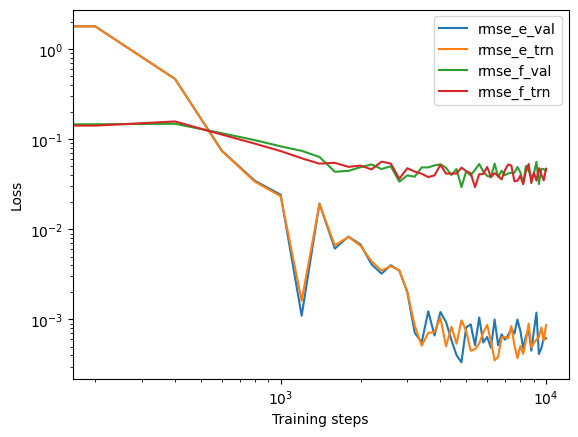

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

with open("./DeePMD-kit_Tutorial/01.train/lcurve.out") as f:
    headers = f.readline().split()[1:]
lcurve = pd.DataFrame(np.loadtxt("./DeePMD-kit_Tutorial/01.train/lcurve.out"), columns=headers)
legends = ["rmse_e_val", "rmse_e_trn", "rmse_f_val" , "rmse_f_trn" ]

for legend in legends:
    plt.loglog(lcurve["step"], lcurve[legend], label = legend )
plt.legend()
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

### 4 冻结模型 <a id ='freeze'></a>

在训练结束时，应该将保存在 TensorFlow 的 `checkpoint` 文件中的模型参数冻结为一个模型文件，通常以扩展名 .pb 结束。只需执行以下命令：

In [14]:
# # 进入 DeePMD-kit_Tutorial/01.train/ 训练文件夹并冻结模型
! cd DeePMD-kit_Tutorial/01.train/ && dp freeze -o graph.pb

Instructions for updating:
non-resource variables are not supported in the long term
/opt/deepmd-kit-2.2.1/lib/python3.10/importlib/__init__.py:169: UserWarning: The NumPy module was reloaded (imported a second time). This can in some cases result in small but subtle issues and is discouraged.
  _bootstrap._exec(spec, module)
2023-04-26 21:15:08.378296: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-26 21:15:08.378335: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
DEEPMD INFO    The following nodes will be frozen: ['model_type', 'descrpt_attr/rcut', 'descrpt_attr/ntypes', 'model_attr/tmap', 'model_attr/model_type', 'model_attr/model_version', 'train_attr/min_nbor_dist', 'train_attr/training_script', 'o_energy', 'o_force', 

它将在当前目录中输出一个名为 *graph.pb* 的模型文件。

<span style="color:purple; font-weight:bold">到目前为止，我们就获得了一个使用 DeePMD-kit 通过高精度的从头算分子动力学数据获得的深度势能模型：*DeePMD-kit_Tutorial/01.train/graph.pb*</span>

### 5 测试模型 <a id ='test'></a>

让我们来检查一下训练模型的效果：

In [15]:
! cd DeePMD-kit_Tutorial/01.train/ && dp test -m graph.pb -s ../00.data/validation_data

Instructions for updating:
non-resource variables are not supported in the long term
/opt/deepmd-kit-2.2.1/lib/python3.10/importlib/__init__.py:169: UserWarning: The NumPy module was reloaded (imported a second time). This can in some cases result in small but subtle issues and is discouraged.
  _bootstrap._exec(spec, module)
2023-04-26 21:15:12.603844: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-26 21:15:12.603881: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
DEEPMD WARNING You can use the environment variable DP_INFER_BATCH_SIZE tocontrol the inference batch

让我们计算预测数据和原始数据之间的相关性并可视化查看一下。

In [16]:
import dpdata

training_systems = dpdata.LabeledSystem("./DeePMD-kit_Tutorial/00.data/training_data", fmt = "deepmd/npy")  # 得到训练数据点
predict = training_systems.predict("./DeePMD-kit_Tutorial/01.train/graph.pb")  # 得到预测数据点

2023-04-26 21:15:14.084334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 21:15:14.979991: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-26 21:15:14.980068: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-26 21:15:14.980078: W 

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-04-26 21:15:16.176068: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 21:15:16.176935: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-26 21:15:16.176958: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-26 21:15:16.176976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bohrium-14076-1015294): /proc/driver/nvidia/version does 

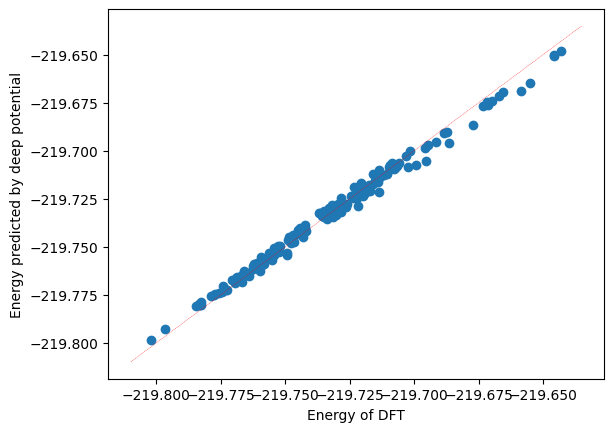

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(training_systems["energies"], predict["energies"])

x_range = np.linspace(plt.xlim()[0], plt.xlim()[1])

plt.plot(x_range, x_range, "r--", linewidth = 0.25)
plt.xlabel("Energy of DFT")  # 设置 x 轴标题
plt.ylabel("Energy predicted by deep potential")  # 设置 y 轴标题
plt.show()

### 6 使用 LAMMPS 进行 MD 计算 <a id ='lammpsmd'></a>

该模型可以驱动 LAMMPS 中的分子动力学模拟。

In [18]:
! cd ./DeePMD-kit_Tutorial/02.lmp && cp ../01.train/graph.pb ./ && tree -L 1

.
├── conf.lmp
├── graph.pb
└── in.lammps

0 directories, 3 files


这里的`conf.lmp`给出了气相甲烷分子动力学模拟的初始构型。



文件`in.lammps`是LAMMPS的输入脚本。你可以检查`in.lammps`，可以发现它是一个相当标准的 LAMMPS 分子动力学模拟输入文件（关于 LAMMPS 分子动力学模拟输入文件的更多信息，可以阅读[「超详细「深度势能」材料计算上手指南｜章节 1」](https://bohrium.dp.tech/notebook/879b6a3a9d394448913ca1ce7de257ec)

其中只有两行例外：

```
pair_style  deepmd graph.pb
pair_coeff  * *
```

其中调用了 DeePMD 的 pair_style，提供了模型文件 `graph.pb`，这意味着原子间相互作用将由存储在文件`graph.pb`中的 DP 模型进行计算。

在具有兼容版本的 LAMMPS 的环境中，可以通过以下命令执行深度势分子动力学模拟：

In [19]:
! cd ./DeePMD-kit_Tutorial/02.lmp && lmp -i in.lammps

This LAMMPS executable is in a conda environment, but the environment has
not been activated. Libraries may fail to load. To activate this environment
please see https://conda.io/activation.
LAMMPS (23 Jun 2022 - Update 1)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Loaded 1 plugins from /opt/deepmd-kit-2.2.1/lib/deepmd_lmp
Reading data file ...
  triclinic box = (0 0 0) to (10.114259 10.263124 10.216793) with tilt (0.036749877 0.13833062 -0.056322169)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  5 atoms
  read_data CPU = 0.006 seconds
DeePMD-kit WARNING: Environmental variable OMP_NUM_THREADS is not set. Tune OMP_NUM_THREADS for the best performance. See https://deepmd.rtfd.io/parallelism/ for more information.
Summary of lammps deepmd module ...
  >>> Info of deepmd-kit:
  installed to:       /opt/deepmd-kit-2.2.1
  source:             v2.2.1
  source branch:       HEAD
  source commit:      3ac8c

## 参考 <a id ='references'></a>

1. Han Wang, Linfeng Zhang, Jiequn Han, and Weinan E. DeePMD-kit: A deep learning package for many-body potential energy representation and molecular dynamics. Comput. Phys. Comm., 228:178–184, 2018. doi:10.1016/j.cpc.2018.03.016.
2. Jinzhe Zeng, Duo Zhang, Denghui Lu, Pinghui Mo, Zeyu Li, Yixiao Chen, Marián Rynik, Li'ang Huang, Ziyao Li, Shaochen Shi, Yingze Wang, Haotian Ye, Ping Tuo, Jiabin Yang, Ye Ding, Yifan Li, Davide Tisi, Qiyu Zeng, Han Bao, Yu Xia, Jiameng Huang, Koki Muraoka, Yibo Wang, Junhan Chang, Fengbo Yuan, Sigbjørn Løland Bore, Chun Cai, Yinnian Lin, Bo Wang, Jiayan Xu, Jia-Xin Zhu, Chenxing Luo, Yuzhi Zhang, Rhys E. A. Goodall, Wenshuo Liang, Anurag Kumar Singh, Sikai Yao, Jingchao Zhang, Renata Wentzcovitch, Jiequn Han, Jie Liu, Weile Jia, Darrin M. York, Weinan E, Roberto Car, Linfeng Zhang, and Han Wang. DeePMD-kit v2: A software package for Deep Potential models. 2023. doi:10.48550/arXiv.2304.09409.
3. https://docs.deepmodeling.com/projects/deepmd/en/master/index.html
4. https://github.com/deepmodeling/deepmd-kit

<a href="https://bohrium.dp.tech/notebook/759614d6c6314dee84a127f11dfc4723" target="_blank"><img src="https://cdn.dp.tech/bohrium/web/static/images/open-in-bohrium.svg" alt="Open In Bohrium"/></a>